# Process `GARD` results and create tanglegram

Import modules:

In [1]:
import json
import io
import os
import re
import subprocess

import Bio.Phylo
import Bio.SeqIO

from IPython.display import display, Image

import pandas as pd

import rpy2.robjects

import yaml

Read the configuration:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory:

In [3]:
os.makedirs(config['gard_analysis_dir'], exist_ok=True)

`GARD` output a JSON that defines the results and breakpoints.
Read these results:

In [4]:
print(f"Reading GARD results from {config['gard_recomb_json']}")

with open(config['gard_recomb_json']) as f:
    gard_results = json.load(f)

Reading GARD results from results/gard_recomb.json


Process the results under the assumption that GARD found a single breakpoint and therefore two partitions each with a corresponding tree.
Determine the location of the breakpoint and how much it improves AIC, as well as the Newick strings for the tree for each partition.
If there is not a single improved model with a single breakpoint, raise an error as the subsequent code will not work in that case:

In [5]:
if len(gard_results['improvements']) == 1:
    breakpoint = gard_results['improvements']['0']['breakpoints'][0][0]
    deltaAIC = gard_results['improvements']['0']['deltaAICc']
    print(f"Found one breakpoint at nucleotide {breakpoint} that increases AIC by {deltaAIC:.2f}")
else:
    raise ValueError('Failed to find exactly one improvement')
    
gard_partitions = gard_results['breakpointData']
if len(gard_partitions) == 2:
    newicks_gard = [val['tree'] for val in gard_partitions.values()]
else:
    raise ValueError('Not exactly one breakpoint (two partitions)')

Found one breakpoint at nucleotide 1089 that increases AIC by 60.32


`GARD` has annoying renamed the nodes by substituting underscores for all special characters.
Here we get rid of the internal node names and re-name tips back to the original full taxa name:

In [6]:
names = pd.read_csv(config['spikes_metadata'])['name'].tolist()

newicks = []
for newick in newicks_gard:
    tree = Bio.Phylo.read(io.StringIO(newick), 'newick')
    for n in tree.get_nonterminals():
        n.name = None
    for n in tree.get_terminals():
        name_gard = n.name.replace('_', '.')
        name_match = [name for name in names if re.fullmatch(name_gard, name)]
        if len(name_match) != 1:
            raise ValueError(f"Found {len(name_match)} name matches for {name_gard}")
        n.name = name_match[0]
    newicks.append(tree.format('newick'))

Now write the trees to Newick files and run [timetree](https://treetime.readthedocs.io/) on them to get time-tree rooted versions:

In [20]:
timetree_newicks = []

alignment = list(Bio.SeqIO.parse(config['spikes_aligned_codon'], 'fasta'))

for i, newick in enumerate(newicks, start=1):
    
    outdir = os.path.join(config['gard_analysis_dir'], f"partition_{i}")
    print(f"\n\nRunning `treetime` for partition {i} in {outdir}")
    os.makedirs(outdir, exist_ok=True)
    
    # create newick input file
    newick_file = os.path.join(outdir, 'tree.newick')
    with open(newick_file, 'w') as f:
        f.write(newick)
        
    # get alignment for partition
    aln_file = os.path.join(outdir, 'alignment.fasta')
    if i == 1:
        Bio.SeqIO.write([a[: breakpoint] for a in alignment], aln_file, 'fasta')
    elif i == 2:
        Bio.SeqIO.write([a[breakpoint:] for a in alignment], aln_file, 'fasta')
    else:
        raise ValueError('code assumes just one partition')
        
    # run timetree    
    cmds = ['treetime',
            '--aln', aln_file,
            '--dates', config['spikes_metadata'],
            '--tree', newick_file,
            '--outdir', outdir,
            '--verbose', '0',
            ]
    result = subprocess.run(cmds, check=True, capture_output=True)
    timetree = Bio.Phylo.read(os.path.join(outdir, 'timetree.nexus'), 'nexus')
    print(result.stdout.decode())
    newick = os.path.join(outdir, 'timetree.newick')
    print(f"Writing tree to {newick}")
    Bio.Phylo.write(timetree, newick, 'newick')
    timetree_newicks.append(newick)



Running `treetime` for partition 1 in results/gard_analysis/partition_1

Attempting to parse dates...
	Using column 'name' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.

0.00	-TreeAnc: set-up

0.22	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

Inferred sequence evolution model (saved as results/gard_analysis/partition_1/sequence_evolution_model.txt):
Substitution rate (mu): 1.0

Equilibrium frequencies (pi_i):
  A: 0.2418
  C: 0.1768
  G: 0.1965
  T: 0.375
  -: 0.01

Symmetrized rates from j->i (W_ij):
	A	C	G	T	-
  A	0	1.5546	1.8153	0.4041	2.4436
  C	1.5546	0	1.0074	2.9192	0.8614
  G	1.8153	1.0074	0	0.8844	2.9491
  T	0.4041	2.91

Use `rpy2` to read the tree into `dendextend`.
The use of `rpy2` is based loosely on [here](https://biopython.org/wiki/Phylo_cookbook).
The reading of trees into `dendextend` is based loosely on [here](https://stackoverflow.com/questions/62063675/how-to-use-dendextend-read-newick-phylogenetic-tree-for-tree-compare).
Then create a tanglegram as described [here](https://cran.r-project.org/web/packages/dendextend/vignettes/dendextend.html#tanglegram), untangle it, and plot it to a PNG:

In [22]:
_ = rpy2.robjects.r(f"""
    library(dendextend)
    library(DECIPHER)
    
    dend1 <- ReadDendrogram('results/gard_analysis/partition_1/timetree.newick',
                            internalLabels=FALSE,
                            keepRoot=FALSE) %>%
             as.dendrogram
    dend2 <- ReadDendrogram('results/gard_analysis/partition_2/timetree.newick',
                            internalLabels=FALSE,
                            keepRoot=FALSE) %>%
             as.dendrogram
    dends <- dendlist(dend1, dend2)
    
    options(warn=-1)  # suppress a lot of warnings
    dends_untangled <- dends %>% untangle(method='step1side')
    options(warn=0)
    cat("entanglement went from",
        dends %>% entanglement,
        "to",
        dends_untangled %>% entanglement)
        
    png("_temp.png", width=6, height=5, res=750, units="in")
    dends_untangled %>% 
      tanglegram(main_left="nucleotides 1 to {breakpoint}",
                 main_right="nucleotides {breakpoint} to {len(alignment[0])}",
                 columns_width=c(4, 0.9, 4),
                 axes=FALSE,
                 highlight_distinct_edges=FALSE,
                 common_subtrees_color_lines=FALSE,
                 edge.lwd=1,
                 lwd=2,
                 color_lines="lightblue",
                 lab.cex=0.3,
                 cex_main_left=0.8,
                 cex_main_right=0.8,
                 )
    dev.off()    
    """)

entanglement went from 0.07710944 to 0.04783153

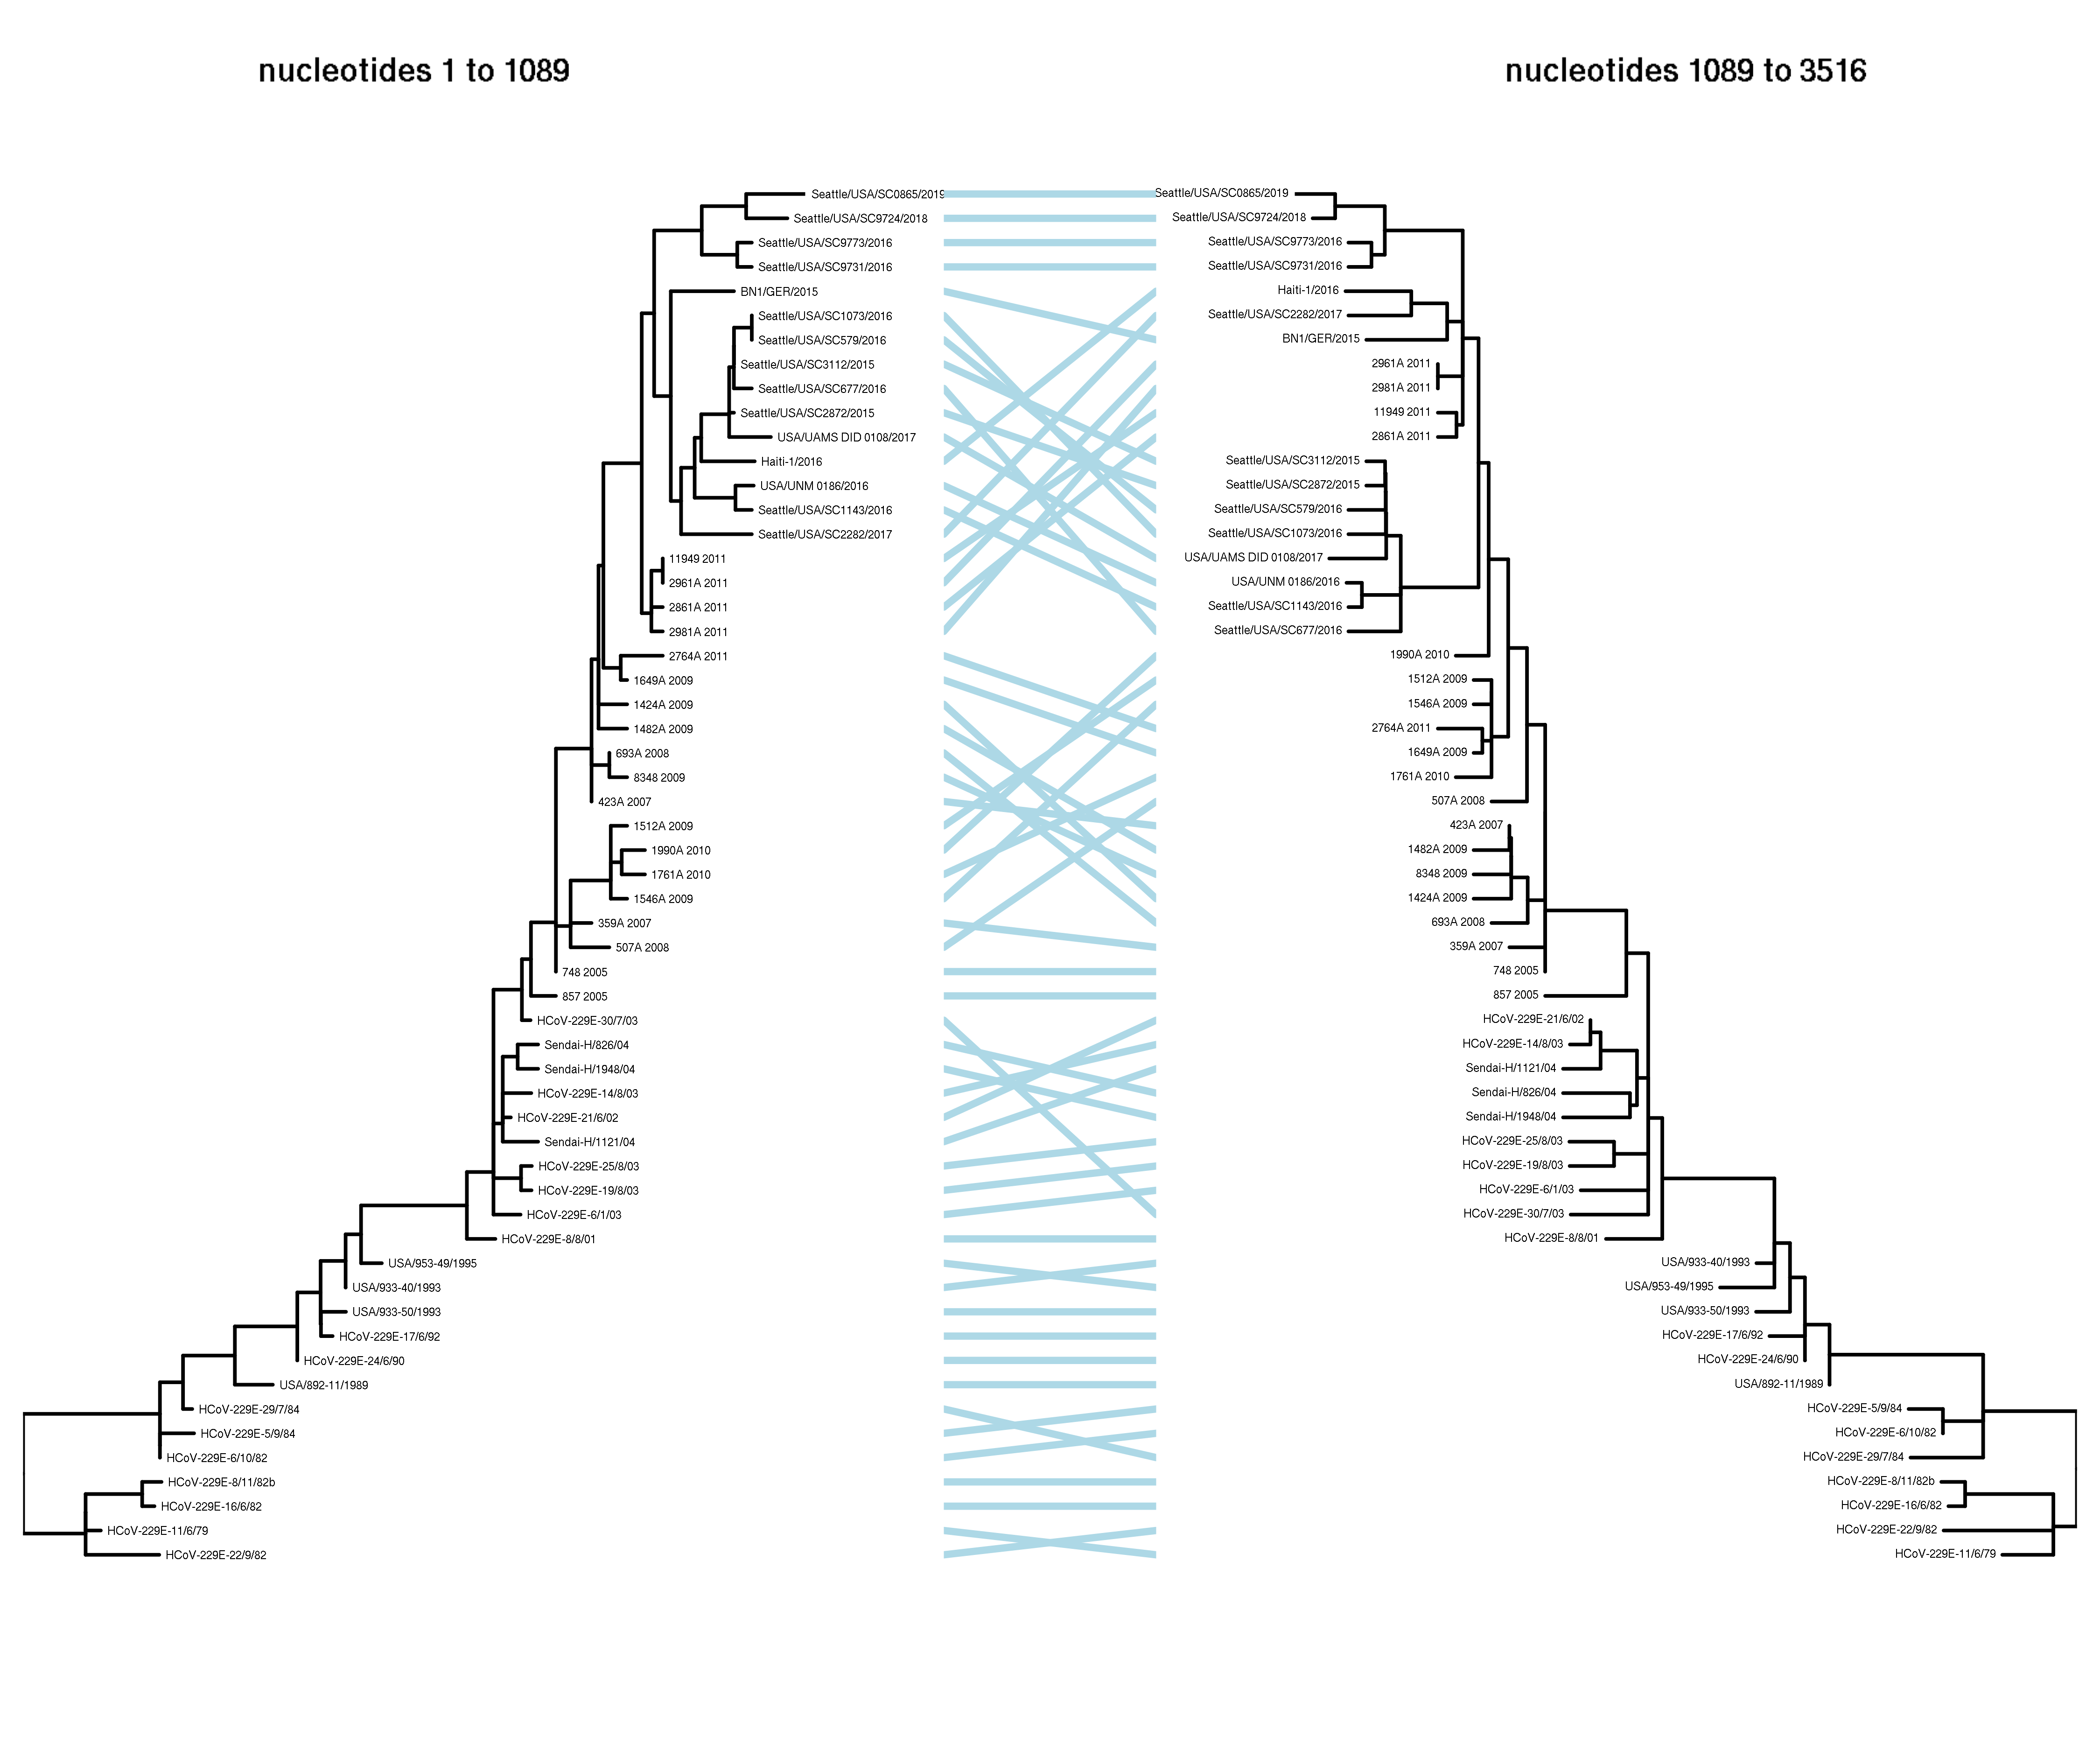

In [25]:


display(Image('_temp.png'))